# Installing Required Libraries

In [ ]:
!pip install torch torchvision cleanvision scikit-learn matplotlib numpy onnx opencv-python-headless pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16

# Importing Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from google.colab import drive
import shutil
from cleanvision import Imagelab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hyperparameter Tuning

In [ ]:
image_size = 299
num_classes = 12
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Defining Directories

In [ ]:
# Directories
train_dir = "/content/drive/MyDrive/I2V/cleaned_train"
val_dir = "/content/drive/MyDrive/I2V/vehicle_dataset/val"
output_dir = "/content/drive/MyDrive/I2V/Inceptionv3"
# metrics_file = os.path.join(output_dir, "training_metrics.txt")
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load pre-trained Inception_v3

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load pre-trained Inception V3 with default aux_logits=True
model = models.inception_v3(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


In [ ]:
# Loss and optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Initialize metrics


In [ ]:
# Function to compute mAP (simplified for multi-class classification)
def compute_map(true_labels, pred_probs, num_classes):
    # Convert to binary relevance (one-hot encoded true labels)
    true_labels_one_hot = np.zeros((len(true_labels), num_classes))
    for i, label in enumerate(true_labels):
        true_labels_one_hot[i, label] = 1

    # Compute Average Precision per class and mean
    average_precisions = []
    for c in range(num_classes):
        true_c = true_labels_one_hot[:, c]
        scores_c = pred_probs[:, c]
        if true_c.sum() == 0:  # Skip if no positive instances
            continue
        sorted_indices = np.argsort(scores_c)[::-1]
        true_c_sorted = true_c[sorted_indices]
        precision_at_k = np.cumsum(true_c_sorted) / (np.arange(len(true_c_sorted)) + 1)
        ap = np.sum(precision_at_k * true_c_sorted) / max(true_c.sum(), 1)
        average_precisions.append(ap)

    return np.mean(average_precisions) if average_precisions else 0.0

In [ ]:
def compute_metrics(true_labels, pred_labels, pred_probs, epoch, save_file):
    accuracy = 100 * (true_labels == pred_labels).mean()
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    m_ap = compute_map(true_labels, pred_probs, num_classes)
    cm = confusion_matrix(true_labels, pred_labels)

    metrics_str = (
        f"Validation Metrics - Epoch {epoch+1}:\n"
        f"Accuracy: {accuracy:.2f}%\n"
        f"Precision: {precision:.4f}\n"
        f"Recall: {recall:.4f}\n"
        f"F1 Score: {f1:.4f}\n"
        f"mAP: {m_ap:.4f}\n"
        f"Confusion Matrix:\n{cm}\n\n"
    )
    print(metrics_str)

    with open(save_file, 'a') as f:
        f.write(metrics_str)

    return accuracy, cm

In [ ]:
# Training loop with learning curves
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0

In [ ]:
# Initialize metrics file
with open(os.path.join(output_dir, "training_metrics.txt"), 'w') as f:
    f.write("Training Metrics Log\n\n")

In [ ]:
metrics_file = "/content/drive/MyDrive/I2V/Inceptionv3/training_metrics.txt"

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        # Inception V3 returns (main_output, aux_output) in training mode
        outputs, aux_outputs = model(images)
        # Compute loss for both outputs
        loss_main = criterion(outputs, labels)
        loss_aux = criterion(aux_outputs, labels)
        loss = loss_main + 0.4 * loss_aux  # Weight auxiliary loss (common practice)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    # Validation phase (eval mode uses only main output)
    model.eval()
    val_loss = 0.0
    val_true = []
    val_pred = []
    val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Single output in eval mode
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            _, predicted = torch.max(outputs, 1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(predicted.cpu().numpy())
            val_probs.extend(probs)

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_acc, cm = compute_metrics(np.array(val_true), np.array(val_pred), np.array(val_probs), epoch, metrics_file)
    val_accuracies.append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, os.path.join(output_dir, "inception_v3_best.pt"))
        print(f"Saved best model with Validation Accuracy: {val_acc:.2f}%")

Epoch [1/10], Train Loss: 1.8096
Validation Metrics - Epoch 1:
Accuracy: 69.02%
Precision: 0.7276
Recall: 0.6902
F1 Score: 0.6917
mAP: 0.6700
Confusion Matrix:
[[102   0  16   0   1   0   2   0   0   0  15   1]
 [  2  61   0   0   0   0   0   6   0   0   0   0]
 [  1   0  61   1   0   0   1   1   0   0   4   2]
 [  1   0   9  11   1   0   0   0   0   0  13   0]
 [  0   0   0   0   6   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [  4   0  12   4   0   0  62   0   0   0   5  15]
 [  2   3   0   2   0   0   0  54   0   0   8   0]
 [  3   0   3   0   2   0   1   0   0   0   3   0]
 [  0   0   0   0   0   0   0   0   0   2   1   0]
 [  2   4  59   0   0   0   3   0   0   0  79  10]
 [  0   0   5   2   0   0   0   0   0   0   6  90]]


Validation Loss: 1.1037
Saved best model with Validation Accuracy: 69.02%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [2/10], Train Loss: 1.0349
Validation Metrics - Epoch 2:
Accuracy: 74.90%
Precision: 0.7525
Recall: 0.7490
F1 Score: 0.7406
mAP: 0.7199
Confusion Matrix:
[[112   2   1   0   0   0   3   6   0   0  12   1]
 [  0  65   0   0   0   0   0   4   0   0   0   0]
 [  2   0  31   5   0   0   7   1   0   2  20   3]
 [  2   1   1  21   0   0   0   4   0   0   4   2]
 [  1   1   0   0   3   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  3   0   0   3   0   0  87   2   0   3   4   0]
 [  0  19   0   0   0   0   0  50   0   0   0   0]
 [  1   8   0   0   0   0   2   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [  6   2   3   4   0   0  10   7   0   3 113   9]
 [  1   0   1   3   0   0   4   0   0   0   6  88]]


Validation Loss: 0.7714
Saved best model with Validation Accuracy: 74.90%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [3/10], Train Loss: 0.7887
Validation Metrics - Epoch 3:
Accuracy: 71.50%
Precision: 0.7786
Recall: 0.7150
F1 Score: 0.7043
mAP: 0.7567
Confusion Matrix:
[[117   0   0   0   1   0   1   0   1   0  17   0]
 [  0  55   0   0   0   0   0  10   2   1   1   0]
 [  4   0  43   2   0   0   5   2   0   0  14   1]
 [  1   0   0  23   0   0   0   3   0   0   8   0]
 [  1   0   0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  5   0   2   3   3   0  84   0   0   0   5   0]
 [  1   1   0   0   0   0   0  60   2   0   5   0]
 [  1   0   0   0   0   0   1   0   8   1   1   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [  9   0   3   2   4   0   8   0   0   0 130   1]
 [  4   0   1  51   3   0   2   0   0   0  23  19]]


Validation Loss: 0.9452


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [4/10], Train Loss: 0.6837
Validation Metrics - Epoch 4:
Accuracy: 72.03%
Precision: 0.7568
Recall: 0.7203
F1 Score: 0.7129
mAP: 0.7661
Confusion Matrix:
[[107   6   1   0   2   0   5   1   0   1  14   0]
 [  0  68   0   0   0   0   0   1   0   0   0   0]
 [  2   3  37   0   0   0   7   1   0   0  20   1]
 [  2   4   0  16   0   0   2   6   1   0   3   1]
 [  0   2   0   0   3   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0]
 [  1   0   1   0   0   0  84   0   0   4  12   0]
 [  0  51   0   0   0   0   0  17   1   0   0   0]
 [  0   4   0   0   0   0   0   0   6   0   2   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [  7   3   5   0   0   0  14   2   0   2 119   5]
 [  2   0   0   0   0   0   9   0   0   0   1  91]]


Validation Loss: 0.8636


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [5/10], Train Loss: 0.5117
Validation Metrics - Epoch 5:
Accuracy: 78.56%
Precision: 0.8147
Recall: 0.7856
F1 Score: 0.7865
mAP: 0.8660
Confusion Matrix:
[[113   0   2   5   4   0   3   2   0   0   7   1]
 [  0  37   0   1   4   0   0  25   2   0   0   0]
 [  5   0  49   2   1   1   1   2   0   0   9   1]
 [  2   0   1  24   0   0   0   2   0   0   4   2]
 [  0   0   0   0   6   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   1   0   0  92   0   0   1   4   4]
 [  0   0   0   0   1   0   0  67   1   0   0   0]
 [  2   0   0   0   2   0   0   1   6   0   1   0]
 [  0   0   0   0   1   0   0   0   0   2   0   0]
 [ 17   0   5  11   2   0   5   2   0   2 106   7]
 [  0   0   1   2   0   0   2   0   0   0   0  98]]


Validation Loss: 0.6515
Saved best model with Validation Accuracy: 78.56%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [6/10], Train Loss: 0.4044
Validation Metrics - Epoch 6:
Accuracy: 78.43%
Precision: 0.7897
Recall: 0.7843
F1 Score: 0.7762
mAP: 0.8573
Confusion Matrix:
[[119   2   1   1   0   0   1   4   0   0   8   1]
 [  0  62   0   0   0   0   0   7   0   0   0   0]
 [  0   1  55   1   0   1   4   2   0   0   4   3]
 [  2   1   1  16   0   0   0   9   0   0   3   3]
 [  2   0   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  5   1   0   2   0   0  89   0   0   0   4   1]
 [  0   1   0   0   0   0   0  67   1   0   0   0]
 [  2   0   0   1   0   0   1   2   5   0   1   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [ 14   3  22   4   0   0   7   9   0   0  84  14]
 [  2   0   1   2   0   0   1   1   0   0   1  95]]


Validation Loss: 0.7738


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [7/10], Train Loss: 0.4305
Validation Metrics - Epoch 7:
Accuracy: 78.69%
Precision: 0.7949
Recall: 0.7869
F1 Score: 0.7813
mAP: 0.8269
Confusion Matrix:
[[121   0   2   0   0   0   2   0   0   0  12   0]
 [  0  65   0   0   0   0   0   2   0   0   2   0]
 [  3   1  47   0   1   1   4   0   0   0  13   1]
 [  1   0   3  12   0   0   2   0   0   0  16   1]
 [  0   0   0   0   6   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   4   0   0   0  89   0   0   0   8   1]
 [  3   6   0   1   2   0   0  50   3   1   3   0]
 [  0   1   0   0   0   0   2   0   4   1   4   0]
 [  0   0   0   0   0   0   0   0   0   2   1   0]
 [ 20   0   9   0   0   0  15   0   0   0 107   6]
 [  2   0   0   0   0   0   1   0   0   0   2  98]]


Validation Loss: 0.7111
Saved best model with Validation Accuracy: 78.69%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [8/10], Train Loss: 0.3832
Validation Metrics - Epoch 8:
Accuracy: 82.75%
Precision: 0.8483
Recall: 0.8275
F1 Score: 0.8295
mAP: 0.9013
Confusion Matrix:
[[ 98   0   2   1   6   0  12   1   0   1  15   1]
 [  0  62   0   0   0   0   0   4   0   3   0   0]
 [  2   0  47   0   0   1   2   0   0   1  16   2]
 [  0   0   2  20   0   0   1   2   0   0   7   3]
 [  0   0   0   0   6   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   1   0  94   0   0   0   7   0]
 [  0   2   0   0   2   0   0  61   1   3   0   0]
 [  1   1   0   0   0   0   0   0   9   1   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [  6   0   5   1   0   0   6   0   0   1 132   6]
 [  0   0   1   0   0   0   2   0   0   0   0 100]]


Validation Loss: 0.6180
Saved best model with Validation Accuracy: 82.75%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [9/10], Train Loss: 0.3706
Validation Metrics - Epoch 9:
Accuracy: 60.65%
Precision: 0.7600
Recall: 0.6065
F1 Score: 0.5797
mAP: 0.7931
Confusion Matrix:
[[ 44   0   3   8   0   0   0   5   0   0  28  49]
 [  0  20   0   9   0   0   0  40   0   0   0   0]
 [  0   0  39   8   0   0   0   1   0   0  11  12]
 [  0   0   0  24   0   0   0   2   0   0   7   2]
 [  0   0   0   0   4   0   0   0   0   0   2   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   1  17   0   0  27   0   0   0  36  21]
 [  0   0   0   3   0   0   0  65   1   0   0   0]
 [  0   0   0   3   0   0   0   1   5   0   2   1]
 [  0   0   0   0   0   0   0   0   0   1   2   0]
 [  0   0   5   6   0   0   0   1   0   0 135  10]
 [  0   0   0   0   0   0   0   0   0   0   4  99]]


Validation Loss: 1.7182


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [10/10], Train Loss: 0.2736
Validation Metrics - Epoch 10:
Accuracy: 84.84%
Precision: 0.8558
Recall: 0.8484
F1 Score: 0.8461
mAP: 0.9311
Confusion Matrix:
[[124   0   2   0   2   0   3   2   0   0   4   0]
 [  0  66   0   0   0   0   0   3   0   0   0   0]
 [  6   0  53   0   2   1   4   1   0   0   4   0]
 [  1   0   1  17   0   0   3   2   0   0   8   3]
 [  1   0   0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  1   0   0   0   1   0  99   0   0   0   1   0]
 [  0   5   0   1   0   0   0  62   1   0   0   0]
 [  1   0   0   0   2   0   0   0   7   0   2   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [ 10   0   9   1   0   1  14   2   0   0 118   2]
 [  0   0   2   0   0   0   3   0   0   0   4  94]]


Validation Loss: 0.4602
Saved best model with Validation Accuracy: 84.84%


# Visualizing Performance Metrics

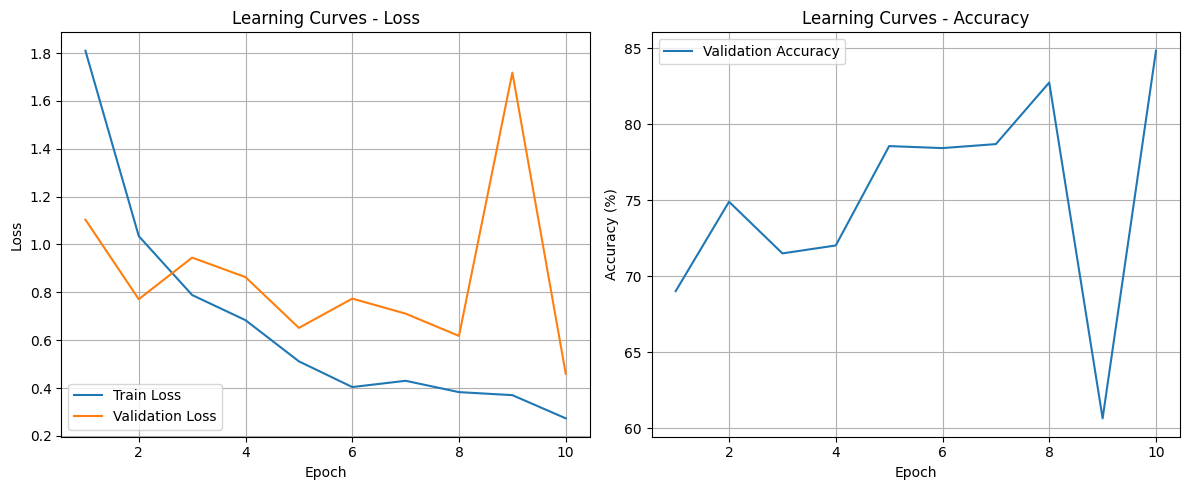

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves - Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curves - Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "learning_curves.png"))
plt.show()

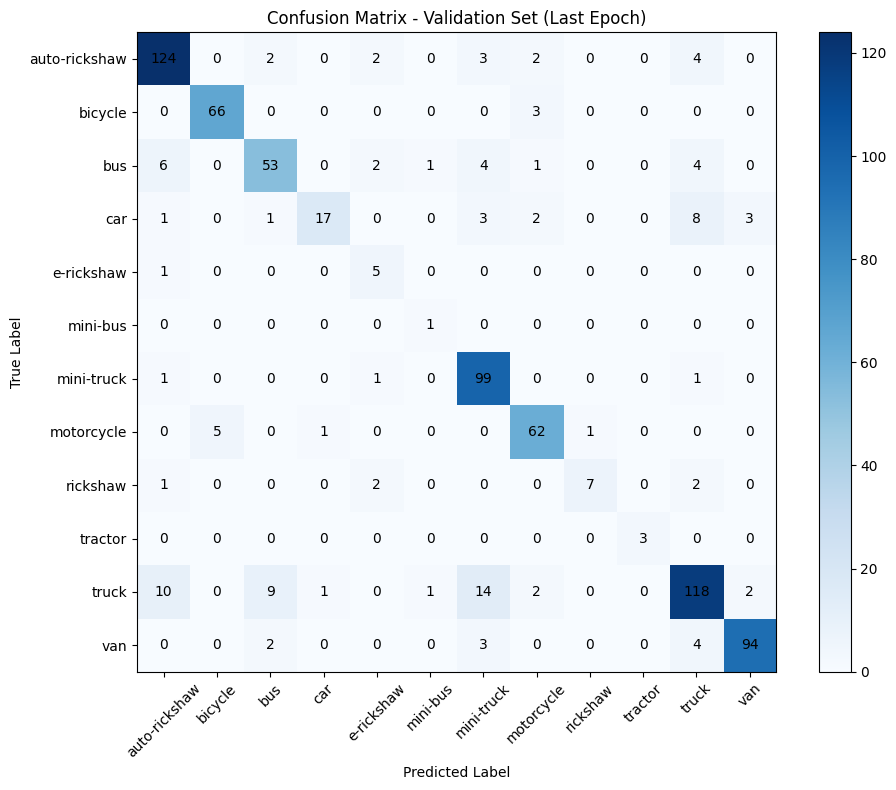

Training complete. Best Validation Accuracy: 84.84%


In [ ]:
# Plot confusion matrix (using the last epoch's validation CM)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Set (Last Epoch)')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, val_dataset.classes, rotation=45)
plt.yticks(tick_marks, val_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

print(f"Training complete. Best Validation Accuracy: {best_val_acc:.2f}%")

# Saving Model

In [ ]:
# Use an image size compatible with Inception V3 (299x299)
image_size = 299  # Standard input size for Inception V3
dummy_input = torch.randn(1, 3, image_size, image_size).to(device)
torch.onnx.export(
    model,
    dummy_input,
    os.path.join(output_dir, "inception_v3_best.onnx"),
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11,
)
print("Model exported to ONNX")

Model exported to ONNX
